## Importing Packages

In [13]:
import pandas as pd
import numpy as np
import tqdm
import pickle
from pprint import pprint
import os

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

#sklearn
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel



In [ ]:
! pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 3.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=949a43551ff78b995340bc3acad21a2cb08f7b3b4005c32b9b03415d74dc9789
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [2]:
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('processed_tweets.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

## Train-Test Split

In [4]:
X_train, X_test = train_test_split(df.tweet, test_size=0.2, random_state=42)
X_train

20180    [congrats, lead, nonprofit, organization, dedi...
17391    [youre, pet, owner, new, york, know, toxic, in...
9976                 [restock, feel, good, brooklynwineco]
6257     [since, percent, excess, heat, retain, earth, ...
6245     [shorebird, watch, big, business, new, jersey,...
                               ...                        
11964    [ooh, yourcbdstorebk, union, berkeley, cbd, st...
21575    [meet, horticultural, therapist, garden, progr...
5390     [alone, together, gowanus, community, group, s...
860      [new, york, city, experience, dangerous, heat,...
15795    [congratulations, raise, money, thank, partici...
Name: tweet, Length: 17672, dtype: object

In [5]:
X_test

19530    [bundle, new, yorkers, go, dip, freeze, every,...
20241    [congratulations, award, grant, historic, hous...
15031                            [refresh, flower, street]
9960     [mask, thermometers, oximeters, near, ave, bea...
735      [deeply, thankful, haul, trash, recycle, treat...
                               ...                        
16606      [get_repost, member, dl, dd, show, chefs, take]
21677    [know, secure, food, box, family, four, please...
7948                                  [missamericanpienyc]
4630     [dont, trash, tree, mulch, drop, bbp, anytime,...
8439     [virtual, learn, great, option, yourchild, lea...
Name: tweet, Length: 4418, dtype: object

In [6]:
train_list_of_lists = list(X_train.values)

## Bigram-Trigram Models

(I did not incorporate bigrams and trigrams into the model yet)

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(train_list_of_lists, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[train_list_of_lists], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [ ]:
data_words_bigrams = make_bigrams(train_list_of_lists)

## Bag of Words

In [7]:
id2word = Dictionary(train_list_of_lists)
corpus = [id2word.doc2bow(text) for text in train_list_of_lists]

In [8]:
sample = corpus[3000]

for i in range(len(sample)):
    print("Word {} (\"{}\") appears {} time(s).".format(sample[i][0], 
                                                     id2word[sample[i][0]], 
                                                     sample[i][1]))

Word 173 ("class") appears 1 time(s).
Word 572 ("get_repost") appears 1 time(s).
Word 660 ("wine") appears 1 time(s).
Word 692 ("january") appears 1 time(s).
Word 715 ("pizza") appears 1 time(s).
Word 732 ("february") appears 1 time(s).
Word 833 ("thursday") appears 2 time(s).
Word 1022 ("month") appears 1 time(s).
Word 1091 ("dd") appears 1 time(s).
Word 3509 ("pair") appears 2 time(s).


## LDA with Bag of Words

In [9]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=4, 
                     random_state=42,
                     chunksize=100,
                     passes=100,
                     update_every=5,
                     alpha='auto',
                     per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.019*"water" + 0.010*"river" + 0.008*"protect" + 0.008*"new" + '
  '0.008*"clean" + 0.006*"state" + 0.006*"hudson" + 0.006*"environmental" + '
  '0.006*"society" + 0.006*"littoral"'),
 (1,
  '0.014*"us" + 0.011*"new" + 0.011*"thank" + 0.010*"join" + 0.009*"today" + '
  '0.009*"get" + 0.008*"day" + 0.008*"make" + 0.008*"help" + 0.008*"learn"'),
 (2,
  '0.025*"park" + 0.016*"brooklyn" + 0.012*"st" + 0.010*"come" + '
  '0.009*"get_repost" + 0.008*"slope" + 0.008*"good" + 0.008*"corner" + '
  '0.007*"amaze" + 0.007*"house"'),
 (3,
  '0.011*"high" + 0.010*"line" + 0.009*"june" + 0.008*"friday" + '
  '0.008*"ticket" + 0.007*"april" + 0.006*"bio" + 0.006*"business" + '
  '0.006*"update" + 0.006*"staff"')]


In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.294986  0.167010       1        1  46.778907
2     -0.197471  0.172827       2        1  20.061064
0      0.074870 -0.298154       3        1  19.538901
3     -0.172385 -0.041683       4        1  13.621129, topic_info=          Term         Freq        Total Category  logprob  loglift
21        park  1162.000000  1162.000000  Default  30.0000  30.0000
568      water   834.000000   834.000000  Default  29.0000  29.0000
284       come   799.000000   799.000000  Default  28.0000  28.0000
376         us  1527.000000  1527.000000  Default  27.0000  27.0000
416   brooklyn   661.000000   661.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
90          pm   120.414099   211.935513   Topic4  -5.5319   1.4282
1190      gift   118.783545   238.712184   Topic4  -5.5455   1.2956
21        park   139.696291  1162.752859   Topic4  -5.3833  -0.1255
97         sit   106.802847   207.909049   Topic4  -5.6518   1.3274
201        day   111.400221   918.999218   Topic4  -5.6097  -0.1166

[183 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1926      3  0.990494       act
817       2  0.996157     amaze
580       1  0.285665  american
580       3  0.712355  american
1670      4  0.997049   another
...     ...       ...       ...
1471      3  0.992149     whale
1058      4  0.992325   whitman
2264      4  0.991412       win
186       1  0.999248      work
724       1  0.997896      year

[177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=train_list_of_lists, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.2907941943446717


In [10]:
lda_model_bow = gensim.models.LdaMulticore(corpus, num_topics=4, id2word=id2word, passes=100, workers=2)

for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.009*"park" + 0.008*"brooklyn" + 0.008*"open" + 0.008*"st" + 0.007*"come" + 0.007*"order" + 0.007*"get" + 0.007*"us" + 0.006*"day" + 0.005*"today"
Topic: 1 
Words: 0.012*"thank" + 0.011*"us" + 0.010*"community" + 0.009*"new" + 0.009*"learn" + 0.007*"help" + 0.007*"support" + 0.007*"program" + 0.006*"make" + 0.006*"please"
Topic: 2 
Words: 0.008*"gowanus" + 0.008*"get" + 0.007*"park" + 0.006*"join" + 0.006*"one" + 0.005*"link" + 0.005*"small" + 0.005*"bio" + 0.005*"today" + 0.005*"support"
Topic: 3 
Words: 0.013*"water" + 0.011*"new" + 0.008*"river" + 0.006*"protect" + 0.005*"clean" + 0.005*"join" + 0.005*"state" + 0.004*"change" + 0.004*"littoral" + 0.004*"hudson"


In [ ]:
LDAvis_prepared_2 = gensimvis.prepare(lda_model_bow, corpus, id2word)
LDAvis_prepared_2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.025181  0.070484       1        1  33.108194
2      0.206442 -0.135200       2        1  25.840419
3     -0.222461 -0.102478       3        1  21.403757
0      0.041200  0.167194       4        1  19.647630, topic_info=       Term         Freq        Total Category  logprob  loglift
21     park  1173.000000  1173.000000  Default  30.0000  30.0000
568   water   874.000000   874.000000  Default  29.0000  29.0000
194   order   439.000000   439.000000  Default  28.0000  28.0000
18      new  1531.000000  1531.000000  Default  27.0000  27.0000
150   river   465.000000   465.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
445   thank   168.271958  1163.081803   Topic4  -5.5636  -0.3060
376      us   161.082670  1449.700392   Topic4  -5.6072  -0.5700
186    work   138.368284   654.079383   Topic4  -5.7592   0.0739
1029   love   123.275503   411.638537   Topic4  -5.8747   0.4215
130    open   140.059296   976.424193   Topic4  -5.7471  -0.3146

[272 rows x 6 columns], token_table=      Topic      Freq                          Term
term                                               
1926      2  0.996756                           act
2409      3  0.985330  anniesblueribbongeneralstore
391       1  0.996055                        annual
961       4  0.986127                          army
872       1  0.320035                           art
...     ...       ...                           ...
101       1  0.145193                         years
101       2  0.328907                         years
101       3  0.053336                         years
101       4  0.471136                         years
26        4  0.997908                          york

[386 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [ ]:
for index, score in sorted(lda_model_bow[corpus[3000]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_bow.print_topic(index, 4)))


Score: 0.49821075797080994	 
Topic: 0.016*"park" + 0.012*"us" + 0.012*"join" + 0.008*"thank"

Score: 0.46301236748695374	 
Topic: 0.010*"get" + 0.009*"order" + 0.008*"open" + 0.008*"day"

Score: 0.019508961588144302	 
Topic: 0.018*"new" + 0.008*"york" + 0.008*"grant" + 0.006*"congratulations"

Score: 0.01926790364086628	 
Topic: 0.015*"water" + 0.008*"river" + 0.006*"new" + 0.006*"protect"


In [ ]:
# Compute Coherence Score
coherence_model_lda_2 = CoherenceModel(model=lda_model_bow, texts=train_list_of_lists, dictionary=id2word, coherence='c_v')
coherence_lda_2 = coherence_model_lda_2.get_coherence()
print('Coherence Score: ', coherence_lda_2)

Coherence Score:  0.2938788565098576


## LDA with TF-IDF

In [14]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.42466773753051157),
 (1, 0.1766020120629213),
 (2, 0.23014024341235387),
 (3, 0.2832750364803111),
 (4, 0.2366724011621648),
 (5, 0.2832750364803111),
 (6, 0.18979599067454203),
 (7, 0.2143401059677086),
 (8, 0.24462258623808159),
 (9, 0.33186344059309086),
 (10, 0.29674778220154957),
 (11, 0.19428450256362492),
 (12, 0.19638562074430463),
 (13, 0.24300529787323882),
 (14, 0.2088991128043566)]


In [15]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=id2word, passes=100, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.004*"st" + 0.004*"corner" + 0.004*"open" + 0.003*"wine" + 0.003*"come" + 0.003*"get_repost" + 0.002*"brooklyn" + 0.002*"gowanus" + 0.002*"order" + 0.002*"union"
Topic: 1 Word: 0.003*"park" + 0.003*"post" + 0.003*"slope" + 0.003*"photo" + 0.002*"le" + 0.002*"restaurant" + 0.002*"see" + 0.002*"grill" + 0.002*"get" + 0.002*"start"
Topic: 2 Word: 0.005*"thank" + 0.004*"water" + 0.004*"new" + 0.004*"join" + 0.003*"support" + 0.003*"us" + 0.003*"learn" + 0.003*"community" + 0.003*"help" + 0.003*"work"
Topic: 3 Word: 0.004*"happy" + 0.004*"open" + 0.004*"please" + 0.003*"get" + 0.003*"line" + 0.003*"us" + 0.003*"day" + 0.003*"high" + 0.003*"today" + 0.003*"park"


In [ ]:
LDAvis_prepared_3 = gensimvis.prepare(lda_model_tfidf, corpus_tfidf, id2word)
LDAvis_prepared_3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.070308  0.088824       1        1  32.899715
0     -0.105266  0.098974       2        1  31.730350
3      0.131962 -0.061336       3        1  23.251905
1     -0.097005 -0.126462       4        1  12.118031, topic_info=           Term        Freq       Total Category  logprob  loglift
194       order   64.000000   64.000000  Default  30.0000  30.0000
192    delivery   43.000000   43.000000  Default  29.0000  29.0000
56      protect   54.000000   54.000000  Default  28.0000  28.0000
196        pick   42.000000   42.000000  Default  27.0000  27.0000
568       water  103.000000  103.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
276        need    8.284168   80.504219   Topic4  -6.6920  -0.1635
19          nyc    8.054762   65.327513   Topic4  -6.7200   0.0173
572  get_repost    7.939236   59.290937   Topic4  -6.7345   0.0998
485        food    7.399964   67.955216   Topic4  -6.8048  -0.1069
328         may    7.360414   53.822585   Topic4  -6.8102   0.1209

[288 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1926      2  0.962244      act
155       1  0.115768   action
155       2  0.868261   action
818       1  0.827717    april
818       2  0.118245    april
...     ...       ...      ...
26        1  0.166030     york
26        2  0.830150     york
2256      2  0.959300  yorkers
1668      2  0.614537    youth
1668      4  0.378177    youth

[458 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

In [ ]:
for index, score in sorted(lda_model_tfidf[corpus[3000]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 4)))


Score: 0.528406023979187	 
Topic: 0.004*"order" + 0.004*"open" + 0.004*"st" + 0.003*"delivery"

Score: 0.4327649474143982	 
Topic: 0.004*"park" + 0.004*"us" + 0.004*"join" + 0.004*"today"

Score: 0.01952865533530712	 
Topic: 0.005*"new" + 0.005*"water" + 0.003*"protect" + 0.003*"thank"

Score: 0.01930043287575245	 
Topic: 0.004*"thank" + 0.002*"early" + 0.002*"khcc" + 0.002*"el"


In [ ]:
# Compute Coherence Score
coherence_model_lda_3 = CoherenceModel(model=lda_model_tfidf, texts=train_list_of_lists, dictionary=id2word, coherence='c_v')
coherence_lda_3 = coherence_model_lda_3.get_coherence()
print('Coherence Score: ', coherence_lda_3)

Coherence Score:  0.30371951254730767


In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=train_list_of_lists, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.1))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.1))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_2.csv', index=False)
    pbar.close()


  0%|          | 0/540 [00:16<?, ?it/s]

 10%|█         | 55/540 [1:22:03<12:52:09, 95.52s/it]

In [17]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [21]:
results = pd.read_csv('lda_tuning_results.csv')
results.head(20)

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.117242
1,75% Corpus,2,0.01,0.31,0.180934
2,75% Corpus,2,0.01,0.61,0.198977
3,75% Corpus,2,0.01,0.9099999999999999,0.195622
4,75% Corpus,2,0.01,symmetric,0.172741
5,75% Corpus,2,0.31,0.01,0.153577
6,75% Corpus,2,0.31,0.31,0.195611
7,75% Corpus,2,0.31,0.61,0.193260
8,75% Corpus,2,0.31,0.9099999999999999,0.189024
9,75% Corpus,2,0.31,symmetric,0.205633


In [ ]:
sorted.tail(1)

,Validation_Set,Topics,Alpha,Beta,Coherence
248,75% Corpus,10,0.31,0.9099999999999999,0.451215


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

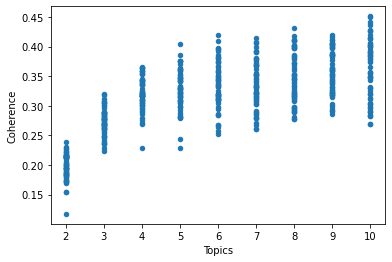

In [23]:
plt.plot(kind='scatter', x='Topics', y='Coherence')